# Assignment - shallow learning

Hi there! In this assignment, you will use shallow learning (including svm, random forests and gradient boosting if you feel up for the challenge) to solve an adapted Question 1 of the winter 2023 exam in applied machine learning:

## Introduction:

During the semester you have become very excited about the field of digital pathology which is an area that is developing rapidly due to advancements in microscopy imaging hardware. These advancements have allowed digitizing glass slides into whole-slide images. You have recently read the paper by [Veeling et al (2018)](https://arxiv.org/abs/1806.03962) and you are thrilled to see that the authors have derived a novel dataset, denoted PatchCamelyon (PCam), that will enable you to develop and benchmark your own machine learning models. As Veeling et al (2018) you are primarily interested in developing machine learning models that based on patches of whole-slide images of lymph node sections can assist pathologist in tumor detection.

The primary objective of this exam is to perform image classification using the PCam dataset. The full dataset consists of 327,680 color images (96x96pxs) extracted from histopathologic scans of lymph node sections. Each image is annotated with a binary label indicating presence of metastatic tissue. For this assignment, however, you are only going to use the subset of the data which have been made available on Kaggle.

### Question 1 (adapted from the exam):
Use non-deep learning to perform image classification (tumor detection). Consider among other things the following:
1. Support vector machines
2. Random forests
3. Boosting
4. A combination of two or all three of the methods
5. Assess the importance of image resolution for the methods you are using

The assignment is posted as a Kaggle competition and is available here: https://www.kaggle.com/t/1f880200648443a3a30878d318cc6e4b


# Hints to get you started (with a very simple model)

In [1]:
from sklearn import svm
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from sklearn import ensemble
import tqdm
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

2023-10-24 13:25:13.978836: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 13:25:14.173312: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-24 13:25:14.173344: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-24 13:25:14.210627: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-24 13:25:15.152485: W tensorflow/stream_executor/pla

Defining a function that grayscale, resize and flattens the image. This function might also become handy (for deep learning later) if the original images are too large for your hardware configuration.

In [2]:
def convert_sample(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image,[32,32]).numpy()
    image = image.reshape(1,-1)
    return image

In [3]:
X = np.load('Xtrain.npy') 
X = np.vstack(list(map(convert_sample,X)))
X = StandardScaler(with_mean=0, with_std=1).fit_transform(X)
print(f'Shape of training data features (observations,features): {X.shape}')

y = np.load('ytrain.npy') 
y = y.reshape(-1,)
print(f'Shape of training data labels (observations,): {y.shape}')

Xtest = np.load('Xtest.npy') 
Xtest = np.vstack(list(map(convert_sample,Xtest)))
Xtest = StandardScaler(with_mean=0, with_std=1).fit_transform(Xtest)
print(f'Shape of training data features (observations,features): {Xtest.shape}')

2023-10-24 13:25:28.029751: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-10-24 13:25:28.029801: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-24 13:25:28.029829: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (default): /proc/driver/nvidia/version does not exist
2023-10-24 13:25:28.030222: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/studio-lab-user/.conda/envs/amlfall23/lib/python3.10/site-packages/sklearn/utils/_param_validation.py

Shape of training data features (observations,features): (26214, 1024)
Shape of training data labels (observations,): (26214,)
Shape of training data features (observations,features): (1638, 1024)


/home/studio-lab-user/.conda/envs/amlfall23/lib/python3.10/site-packages/sklearn/utils/_param_validation.py:591: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


The data is then ready to be applied for training and prediction in a shallow learning model such as the SVM classifier...below just a very very simple illustration on how to construct and train a support vector machine based on the data we have prepared. The predicted file can be submitted to Kaggle for evaluation.

100%|██████████| 13/13 [1:32:58<00:00, 429.15s/it]


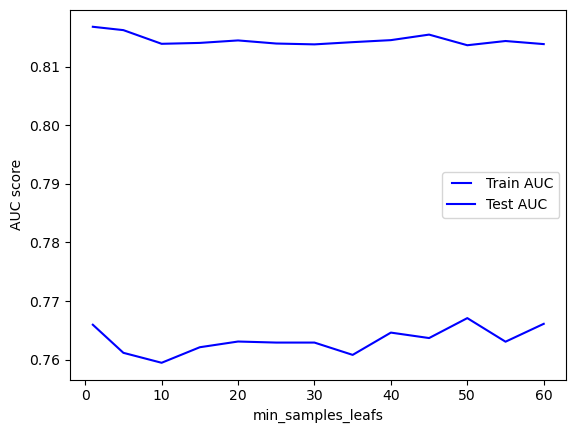

In [5]:
# Hyperparameter searching
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Split the dataset into training and vslidation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

min_samples_leafs = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60]
train_results = []
test_results = []

for min_samples_leaf in tqdm.tqdm(min_samples_leafs):
    gbt_current = ensemble.GradientBoostingClassifier(min_samples_leaf=min_samples_leaf)
    gbt_current.fit(X_train, y_train)
    
    train_pred = gbt_current.predict(X_train)
    false_positive_rate, true_postivie_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_postivie_rate)
    train_results.append(roc_auc)
    
    y_pred_hat = gbt_current.predict(X_val)
    false_positive_rate, true_postivie_rate, thresholds = roc_curve(y_val, y_pred_hat)
    roc_auc = auc(false_positive_rate, true_postivie_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, "b", label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, "b", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min_samples_leafs")
plt.show()

In [6]:
# optimal min_samples_leaf: 50
plt.savefig("min_samples_leafs.png")

<Figure size 640x480 with 0 Axes>

In [5]:
# Extract best parameters
n_estimators_optimal = results.loc[results['Accuracy'].idxmax()]['n_estimators'].astype(int)
min_samples_split_optimal = results.loc[results['Accuracy'].idxmax()]['min_samples_split'].astype(int)
min_samples_leaf_optimal = results.loc[results['Accuracy'].idxmax()]['min_samples_leaf'].astype(int)

In [6]:
print(n_estimators_optimal)
print(min_samples_split_optimal)
print(min_samples_leaf_optimal)

500
25
5


In [7]:
# Initialize the final model
gbt_optimal = ensemble.GradientBoostingClassifier(
                n_estimators=n_estimators_optimal,
                min_samples_split=min_samples_split_optimal,
                min_samples_leaf=min_samples_leaf_optimal,
                )

gbt_optimal.fit(X, y)

y_test_hat = gbt_optimal.predict(Xtest)

In [8]:
ytest_hat = pd.DataFrame({
    'Id': list(range(len(y_test_hat))),
    'Predicted': y_test_hat.reshape(-1,),
})
ytest_hat.to_csv('ytest_hat.csv', index=False)